In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import ttest_ind
import numpy as np
from scipy.stats.stats import pearsonr
from IPython.display import display, Markdown, Latex
plt.style.use('ggplot')
from datetime import date
from statsmodels.stats.outliers_influence import variance_inflation_factor
data_path = '/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/'
from seaborn_qqplot import pplot




/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_19936/1321555209.py:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


### Load mobility-heat and heatwave-control day dataframes

In [5]:
mobility_heat = pd.read_csv(data_path + 'mobility_heat/mobility_heat_clean_90_v1.csv')

In [6]:
heatwave_control = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave_control/heatwave_control_clean_90_v1.csv')

In [7]:
heatwave_control.rename(columns={'datetime': 'date'}, inplace=True)
heatwave_control.rename(columns={'Heat Wave Duration_x': 'Heat Wave Duration'}, inplace=True)


mobility_heat.rename(columns={'datetime': 'date'}, inplace=True)
heatwave_control.drop_duplicates(['location', 'date'], inplace=True)

## Build Intensity Variable


### Clean/Add control day temperature

In [8]:
import glob
import dask.dataframe as dd

In [9]:
daily_max_dic = {}

for state in ['California', 'Oregon', 'Washington', 'British Columbia']:
            
    daily_max_files = glob.glob(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/daily_max/{state}/max*')
    
    temp = dd.read_csv(daily_max_files)
    temp = temp.compute()
    daily_max_dic[state] = temp
    

full_df = pd.concat(daily_max_dic.values())

full_df['datetime'] = pd.to_datetime(full_df[['day', 'month', 'year']])
full_df['datetime_ord'] = [date(x,y,z).toordinal() for x,y,z in zip(full_df['year'], full_df['month'], full_df['day'])]

full_df['location'] = full_df['county'] + ', ' + full_df['state']
full_df.drop_duplicates(['location', 'datetime'], inplace=True)

full_df = full_df[(full_df['month'] != 10)]
full_df = full_df[(full_df['month'] != 4)]



In [12]:
#load and format full temperature dataset

#full_df = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/daily_max/max_temps/max_temps.csv')
#full_df['datetime'] = pd.to_datetime(full_df['datetime'])
us_temps = full_df[full_df['state'].isin(['California', 'Oregon', 'Washington'])]
us_temps['county'] = us_temps['county'] + ' County'
us_temps['location'] = us_temps['county'] + ', ' + us_temps['state']

ca_temps = full_df[full_df['state'] == 'British Columbia']
ca_temps['location'] = ca_temps['county'] + ', ' + ca_temps['state']

nw_temps = pd.concat([us_temps, ca_temps])

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_19936/529959716.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_temps['county'] = us_temps['county'] + ' County'
/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_19936/529959716.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_temps['location'] = us_temps['county'] + ', ' + us_temps['state']
/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_19936/529959716.py:10: SettingWithCopyWarning: 
A value is trying to be set on

In [13]:
mobility_heat['date_heat'] = pd.to_datetime(mobility_heat['date_heat'])

In [14]:
mobility_heat['date_control'] = pd.to_datetime(mobility_heat['date_control'])

In [16]:
mobility_heat

,Unnamed: 0.1,Unnamed: 0,country_region_code,country_region,state,county,metro_area,iso_3166_2_code,census_fips_code,place_id,...,workplaces_control,residential_control,retail_difference,grocery_pharmacy_difference,parks_difference,transit_difference,workplaces_difference,residential_difference,day_of_week,weekend
0,0,48495,US,United States,California,Alameda County,NaN,NaN,6001.0,ChIJWRd5NDfyj4ARc30TGxHHxmg,...,-57.0,25.0,-1.0,1.0,-6.0,2.0,2.0,-1.0,2,0
1,1,48496,US,United States,California,Alameda County,NaN,NaN,6001.0,ChIJWRd5NDfyj4ARc30TGxHHxmg,...,-55.0,24.0,-2.0,0.0,-2.0,0.0,0.0,0.0,3,0
2,2,48533,US,United States,California,Alameda County,NaN,NaN,6001.0,ChIJWRd5NDfyj4ARc30TGxHHxmg,...,-17.0,10.0,3.0,2.0,2.0,-1.0,0.0,0.0,5,1
3,3,48534,US,United States,California,Alameda County,NaN,NaN,6001.0,ChIJWRd5NDfyj4ARc30TGxHHxmg,...,-21.0,7.0,4.0,8.0,12.0,1.0,2.0,1.0,6,1
4,4,48566,US,United States,California,Alameda County,NaN,NaN,6001.0,ChIJWRd5NDfyj4ARc30TGxHHxmg,...,-54.0,20.0,0.0,-2.0,-8.0,-1.0,-1.0,0.0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6534,6534,13369,CA,Canada,British Columbia,Thompson-Nicola,NaN,NaN,NaN,ChIJ_SiQHppZmVMRU1GZA0M1YhU,...,-23.0,0.0,0.0,4.0,-2.0,4.0,0.0,2.0,4,0
6535,6535,13380,CA,Canada,British Columbia,Thompson-Nicola,NaN,NaN,NaN,ChIJ_SiQHppZmVMRU1GZA0M1YhU,...,-22.0,3.0,0.0,-6.0,8.0,9.0,1.0,-3.0,1,0
6536,6536,13381,CA,Canada,British Columbia,Thompson-Nicola,NaN,NaN,NaN,ChIJ_SiQHppZmVMRU1GZA0M1YhU,...,-18.0,0.0,9.0,-4.0,26.0,-13.0,-2.0,0.0,2,0
6537,6537,13383,CA,Canada,British Columbia,Thompson-Nicola,NaN,NaN,NaN,ChIJ_SiQHppZmVMRU1GZA0M1YhU,...,-18.0,-2.0,7.0,3.0,66.0,-11.0,-8.0,1.0,4,0


In [17]:
#remove days on Canadian holidays for heatwave and control days
holidays = pd.read_csv('/Users/shivyucel/Downloads/holidays.csv')
holidays['date'] = pd.to_datetime(holidays['date'])
mobility_heat['holiday'] = [1 if (x in holidays['date'].values) & (y=='British Columbia') else 0 for (x,y) in zip(mobility_heat['date_heat'].values, mobility_heat['state'])]
mobility_heat = mobility_heat[mobility_heat['holiday'] != 1]


mobility_heat['holiday'] = [1 if (x in holidays['date'].values) & (y=='British Columbia') else 0 for (x,y) in zip(mobility_heat['date_control'].values, mobility_heat['state'])]
mobility_heat = mobility_heat[mobility_heat['holiday'] != 1]




/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_19936/782201826.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mobility_heat['holiday'] = [1 if (x in holidays['date'].values) & (y=='British Columbia') else 0 for (x,y) in zip(mobility_heat['date_control'].values, mobility_heat['state'])]


In [18]:
#remove days on American holidays for heatwave and control days

us_hols = pd.read_csv('/Users/shivyucel/Downloads/archive/400_Years_of_Generated_Dates_and_Holidays.csv')
us_hols = us_hols[us_hols['IS_HOLIDAY'] == 1]
us_hols['A_DATE'] = pd.to_datetime(us_hols['A_DATE'])


mobility_heat['us_holiday_heat'] = [1 if (x in us_hols['A_DATE'].values) & (y != 'British Columbia') else 0 for (x,y) in zip(mobility_heat['date_heat'].values, mobility_heat['state'])]
mobility_heat = mobility_heat[mobility_heat['us_holiday_heat'] == 0]


mobility_heat['us_holiday'] = [1 if (x in us_hols['A_DATE'].values) & (y != 'British Columbia') else 0 for (x,y) in zip(mobility_heat['date_control'].values, mobility_heat['state'])]
mobility_heat = mobility_heat[mobility_heat['us_holiday'] == 0]


In [19]:
mobility_heat

,Unnamed: 0.1,Unnamed: 0,country_region_code,country_region,state,county,metro_area,iso_3166_2_code,census_fips_code,place_id,...,grocery_pharmacy_difference,parks_difference,transit_difference,workplaces_difference,residential_difference,day_of_week,weekend,holiday,us_holiday_heat,us_holiday
0,0,48495,US,United States,California,Alameda County,NaN,NaN,6001.0,ChIJWRd5NDfyj4ARc30TGxHHxmg,...,1.0,-6.0,2.0,2.0,-1.0,2,0,0,0,0
1,1,48496,US,United States,California,Alameda County,NaN,NaN,6001.0,ChIJWRd5NDfyj4ARc30TGxHHxmg,...,0.0,-2.0,0.0,0.0,0.0,3,0,0,0,0
2,2,48533,US,United States,California,Alameda County,NaN,NaN,6001.0,ChIJWRd5NDfyj4ARc30TGxHHxmg,...,2.0,2.0,-1.0,0.0,0.0,5,1,0,0,0
3,3,48534,US,United States,California,Alameda County,NaN,NaN,6001.0,ChIJWRd5NDfyj4ARc30TGxHHxmg,...,8.0,12.0,1.0,2.0,1.0,6,1,0,0,0
4,4,48566,US,United States,California,Alameda County,NaN,NaN,6001.0,ChIJWRd5NDfyj4ARc30TGxHHxmg,...,-2.0,-8.0,-1.0,-1.0,0.0,3,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6534,6534,13369,CA,Canada,British Columbia,Thompson-Nicola,NaN,NaN,NaN,ChIJ_SiQHppZmVMRU1GZA0M1YhU,...,4.0,-2.0,4.0,0.0,2.0,4,0,0,0,0
6535,6535,13380,CA,Canada,British Columbia,Thompson-Nicola,NaN,NaN,NaN,ChIJ_SiQHppZmVMRU1GZA0M1YhU,...,-6.0,8.0,9.0,1.0,-3.0,1,0,0,0,0
6536,6536,13381,CA,Canada,British Columbia,Thompson-Nicola,NaN,NaN,NaN,ChIJ_SiQHppZmVMRU1GZA0M1YhU,...,-4.0,26.0,-13.0,-2.0,0.0,2,0,0,0,0
6537,6537,13383,CA,Canada,British Columbia,Thompson-Nicola,NaN,NaN,NaN,ChIJ_SiQHppZmVMRU1GZA0M1YhU,...,3.0,66.0,-11.0,-8.0,1.0,4,0,0,0,0


In [20]:
mobility_heat[['date_heat','control_day']] = mobility_heat[['date_heat','control_day']].apply(pd.to_datetime) #if conversion required

mobility_heat['C'] = (mobility_heat['date_heat'] - mobility_heat['control_day']).dt.days

In [21]:
# get control day temperature
mobility_heat = mobility_heat.merge(nw_temps[['datetime', 'temperature_2m', 'location']], left_on=['location', 'control_day'], right_on=['location', 'datetime'], suffixes=('_heat', '_control'))

In [22]:
mobility_heat['temp_diff'] = mobility_heat['temperature_2m_heat'] - mobility_heat['temperature_2m_control']

/Users/shivyucel/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


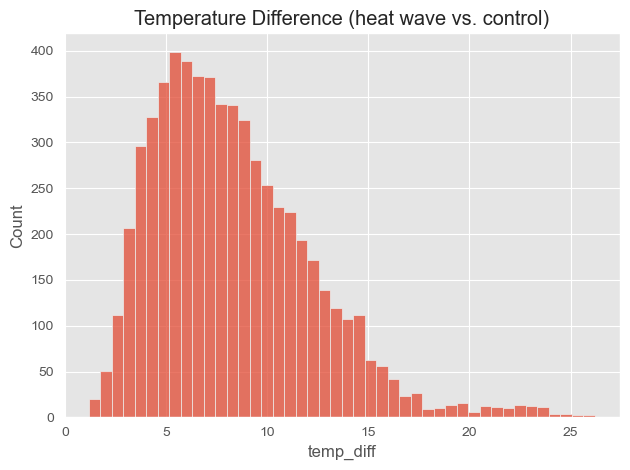

In [23]:
sns.histplot(mobility_heat, x='temp_diff')
plt.title("Temperature Difference (heat wave vs. control)")
plt.tight_layout()
#plt.savefig(data_path + '/img/12_09_2023/temp_diff_dist.png')

### Build Duration Variable
* Duration of heat wave (in days)
* Build stage variable showing how far a day is into a distinct heatwave

In [24]:
# Formatting column names and merging dataframes

In [25]:
heatwave_control.reset_index(inplace=True)

In [26]:
duration_IDs = heatwave_control.drop_duplicates('heat_ID')[['heat_ID', 'Heat Wave Duration']  ]             

In [27]:
duration_IDs.columns = ['heat_ID', 'Heat Wave Duration']

In [28]:
duration_IDs['Heat Wave Duration'].describe()

count    2094.000000
mean        3.563037
std         1.929624
min         2.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        11.000000
Name: Heat Wave Duration, dtype: float64

In [24]:
heatwave_control.drop('Heat Wave Duration', axis=1, inplace=True)
heatwave_control = heatwave_control.merge(duration_IDs, on='heat_ID', how='left')
heatwave_control.drop_duplicates(['location', 'date'], inplace=True)

heatwave_control['dur_ranking'] = heatwave_control['Heat Wave Duration'].rank(pct=True)

In [25]:
#create stage variable
heat_stage = heatwave_control.groupby('heat_ID').apply(lambda x: x.date.sort_values().rank()).reset_index()

In [26]:
heat_stage.columns=['heat_ID', 'index', 'stage']

In [27]:
heat_stage

,heat_ID,index,stage
0,0021b16e-5a43-45ab-bdd0-bd6db65a40d4,6868,1.0
1,0021b16e-5a43-45ab-bdd0-bd6db65a40d4,6968,2.0
2,0021b16e-5a43-45ab-bdd0-bd6db65a40d4,7025,3.0
3,0021b16e-5a43-45ab-bdd0-bd6db65a40d4,7073,4.0
4,0021b16e-5a43-45ab-bdd0-bd6db65a40d4,7146,5.0
...,...,...,...
7456,ffe3c7d5-1e3f-4326-803e-a7decb3c54e5,1334,1.0
7457,ffe3c7d5-1e3f-4326-803e-a7decb3c54e5,1393,2.0
7458,ffe3c7d5-1e3f-4326-803e-a7decb3c54e5,1456,3.0
7459,ffe3c7d5-1e3f-4326-803e-a7decb3c54e5,1513,4.0


In [28]:
heat_stage['stage'].max()

11.0

In [29]:
x = heat_stage.merge(duration_IDs, on='heat_ID')

In [30]:
#get stage variable as a fraction
(x['stage'] / x['Heat Wave Duration']).max()

1.0

# Merge Mobility data with temperature data

In [31]:
heatwave_control = heatwave_control.merge(heat_stage, on=['index', 'heat_ID'])

In [32]:
heatwave_control['date'] = pd.to_datetime(heatwave_control['date'])

In [33]:
heatwave_control_us = heatwave_control[heatwave_control['state'].isin(['California', 'Oregon', 'Washington'])]
heatwave_control_us['county'] = heatwave_control_us['county'] + ' County'
heatwave_control_us['location'] = heatwave_control_us['county'] + ', ' + heatwave_control_us['state']

heatwave_control_ca = heatwave_control[heatwave_control['state'] == 'British Columbia']
heatwave_control_ca['location'] = heatwave_control_ca['county'] + ', ' + heatwave_control_ca['state']

heatwave_control = heatwave_control_us.append(heatwave_control_ca)

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_37599/714079828.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatwave_control_us['county'] = heatwave_control_us['county'] + ' County'
/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_37599/714079828.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatwave_control_us['location'] = heatwave_control_us['county'] + ', ' + heatwave_control_us['state']
/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_37599/714079828.py:6: S

In [34]:
mobility_heat = mobility_heat.merge(heatwave_control[['heat_ID', 'location', 'date', 'Heat Wave Duration', 'dur_ranking', 'stage']], left_on=['location', 'date_heat'], right_on=['location', 'date'])

In [35]:
mobility_heat.reset_index(inplace=True)

In [36]:
mobility_heat[['date_heat','control_day']] = mobility_heat[['date_heat','control_day']].apply(pd.to_datetime) #if conversion required

mobility_heat['C'] = (mobility_heat['date_heat'] - mobility_heat['control_day']).dt.days

In [37]:
x = mobility_heat.copy()
x['stage_frac'] = (mobility_heat['stage'] / mobility_heat['Heat Wave Duration'] )

In [38]:
x.to_csv(data_path + 'mobility_heat/mobility_heat_vars_clean_90_v1.csv')